## ERDAP with erddapy example for ITAE Prawler - 2018 St Matt's (MTITAEPR-1A)

***requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)

In [81]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-05-11 06:14:12.394393


### connecting and basic information

In [82]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://krafla.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [83]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

In [84]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 5 tabledap, 0 griddap, and 0 wms endpoints.'

In [85]:
prawlers = df['Dataset ID'].values
print(prawlers)

['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler']


In [86]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['latitude', 'longitude', 'time', 'Salinity', 'Chlorophyll', 'depth'], ['latitude', 'longitude', 'time', 'Salinity', 'Chlorophyll', 'depth'], ['latitude', 'longitude', 'time', 'Salinity', 'Chlorophyll', 'depth'], ['latitude', 'longitude', 'time', 'Salinity', 'Chlorophyll', 'depth'], ['latitude', 'longitude', 'time', 'Salinity', 'Chlorophyll', 'depth']]


### retrieving and plotting data

In [87]:
constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2018-10-10T00:00:00Z',
    'latitude>=': 45,
    'latitude<=': 90,
    'longitude>=': 180,
    'longitude<=': 210
}

variables = [
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'latitude',
 'longitude',
 'depth',
 'time'
]

d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
           dataset_id='erddap_18mtitaepr1a_prawler',
           variables=variables,
           constraints=constraints
          )

In [88]:
d.get_download_url()

'http://krafla.pmel.noaa.gov:8080/erddap/tabledap/erddap_18mtitaepr1a_prawler.csv?Temperature,Salinity,Chlorophyll,latitude,longitude,depth,time&time>=1514764800.0&time<=1539129600.0&latitude>=45&latitude<=90&longitude>=180&longitude<=210'

In [89]:
df = d.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,Temperature,Salinity,Chlorophyll,latitude,longitude,depth
time,,,,,,
2018-05-01 20:52:30,3.696,32.060,0.339,60.026001,187.210007,5.7
2018-05-01 20:52:30,3.693,32.063,0.315,60.026001,187.210007,5.6
2018-05-01 20:52:30,3.694,32.061,0.375,60.026001,187.210007,6.0
2018-05-01 20:52:30,3.686,32.062,0.339,60.026001,187.210007,5.9
2018-05-01 20:56:15,3.699,32.060,0.327,60.026001,187.210007,5.8


In [90]:
df.tail()

,Temperature,Salinity,Chlorophyll,latitude,longitude,depth
time,,,,,,
2018-05-11 01:11:15,2.275,32.334,0.879,60.026001,187.210007,41.0
2018-05-11 01:11:15,2.278,32.328,0.778,60.026001,187.210007,40.7
2018-05-11 01:11:15,2.285,32.329,0.803,60.026001,187.210007,40.7
2018-05-11 01:11:15,2.277,32.331,0.803,60.026001,187.210007,40.6
2018-05-11 01:11:15,2.270,32.334,0.828,60.026001,187.210007,40.6


In [91]:
#qc
df['Temperature'][df['Temperature']>20]=np.nan

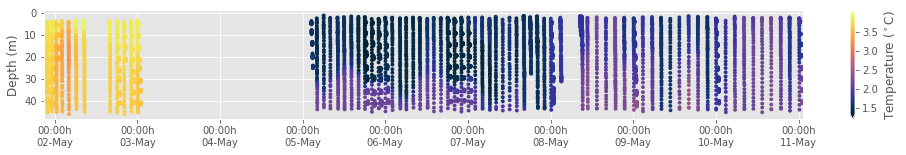

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Temperature'], marker='o', edgecolor='none', cmap=cmocean.cm.thermal)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [93]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['Temperature'].max(), df['Temperature'].min()))


max temp: 3.92
min temp: 1.342


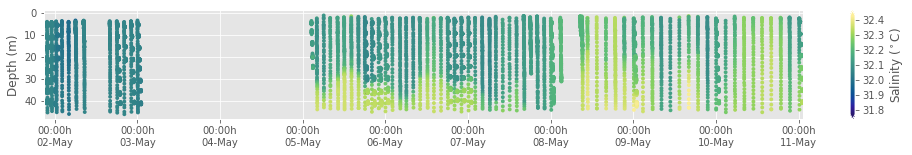

In [94]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Salinity'], marker='o', edgecolor='none', cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [95]:
print("""
max sal: {0:0.4}
min sal: {1:0.4}""".format(df['Salinity'].max(), df['Salinity'].min()))


max sal: 32.43
min sal: 31.77


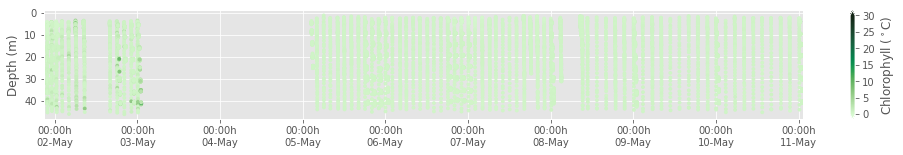

In [96]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Chlorophyll'], marker='o', edgecolor='none', vmin=0, vmax=30, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [97]:
sigmat = sw.dens(s=df['Salinity'],t=df['Temperature'],p=df['depth']) - 1000.

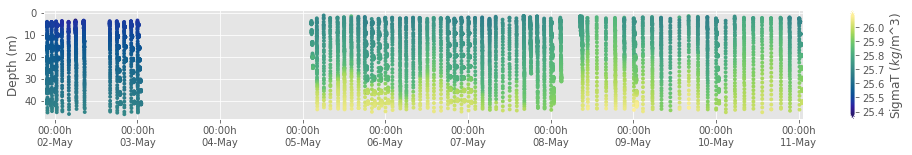

In [98]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=sigmat, marker='o', edgecolor='none', cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('SigmaT ($kg/$m^3)')
ax.set_ylabel('Depth (m)');

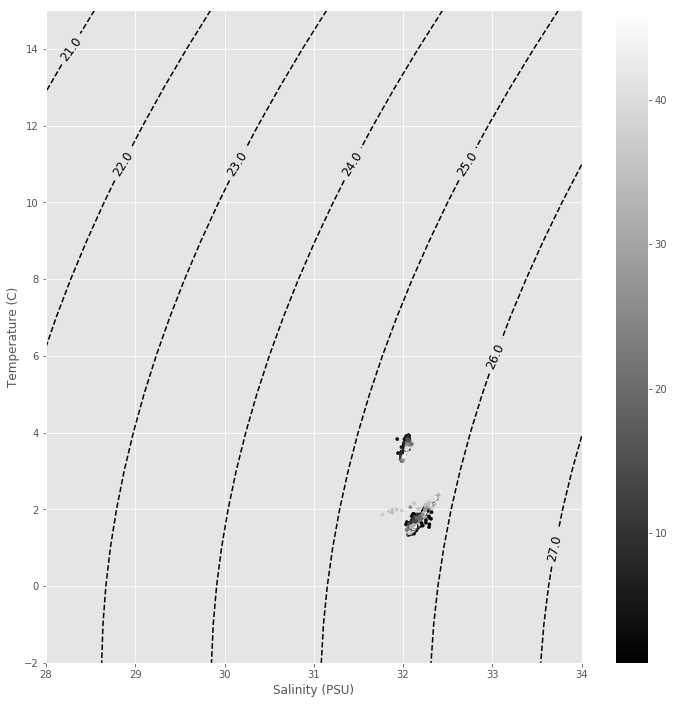

In [99]:
import seawater as sw

def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

fig = plot_salvtemp(df['Salinity'],df['Temperature'],df['depth'])